In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Skripsi/Dataset/data_bersih_GPR.csv")

df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')

# Pilih kolom penting saja
df = df[['DATE','GOLD_PRICE','SILVER_PRICE','GPRD']]

# Hapus missing
df = df.dropna()

print("Total rows after cleaning:", len(df))

Total rows after cleaning: 10562


In [3]:
df.head(10)

,DATE,GOLD_PRICE,SILVER_PRICE,GPRD
10568,1985-01-02,305.5,6.15,115.68
10567,1985-01-03,302.3,6.09,97.43
10566,1985-01-04,303.1,6.03,157.37
10565,1985-01-07,298.2,5.80,105.31
10564,1985-01-08,302.0,6.01,87.40
10563,1985-01-09,300.5,6.01,121.40
10562,1985-01-10,303.8,6.14,140.63
10561,1985-01-11,304.2,6.11,94.85
10560,1985-01-14,299.0,5.94,211.64
10559,1985-01-15,301.8,6.05,97.17


In [4]:
df.tail(10)

,DATE,GOLD_PRICE,SILVER_PRICE,GPRD
9,2025-08-27,3397.42,38.64,210.07
8,2025-08-28,3417.20,39.10,204.20
7,2025-08-29,3448.00,39.70,183.15
6,2025-09-01,3476.47,40.70,147.77
5,2025-09-02,3533.73,40.92,71.82
4,2025-09-03,3559.43,41.22,209.95
3,2025-09-04,3546.17,40.70,126.80
2,2025-09-05,3586.81,41.01,166.42
1,2025-09-07,3591.19,40.86,83.51
0,2025-09-08,3635.84,41.36,117.26


In [5]:
features = ['GOLD_PRICE','SILVER_PRICE','GPRD']
data = df[features].values

In [6]:
train_size = int(len(data) * 0.8)

train_data = data[:train_size]
test_data  = data[train_size:]


In [7]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data)
test_scaled  = scaler.transform(test_data)

data_scaled = np.vstack((train_scaled, test_scaled))
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data)
test_scaled  = scaler.transform(test_data)

data_scaled = np.vstack((train_scaled, test_scaled))


In [8]:
max_time_step = 30

time_step = min(max_time_step, len(data_scaled)//5)

print("Time step used:", time_step)
def create_dataset(dataset, time_step):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i+time_step), :])
        y.append(dataset[i + time_step, 1])  # SILVER_PRICE
    return np.array(X), np.array(y)

time_step = 30

X, y = create_dataset(data_scaled, time_step)


Time step used: 30


In [9]:
def create_dataset(dataset, time_step):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), :])
        y.append(dataset[i+time_step, 1])  # SILVER_PRICE
    return np.array(X), np.array(y)

X, y = create_dataset(data_scaled, time_step)

print("X shape:", X.shape)
print("y shape:", y.shape)
train_size_window = int(len(X) * 0.8)

X_train = X[:train_size_window]
X_test  = X[train_size_window:]

y_train = y[:train_size_window]
y_test  = y[train_size_window:]


X shape: (10531, 30, 3)
y shape: (10531,)


In [10]:
train_size_window = int(len(X) * 0.8)

X_train = X[:train_size_window]
X_test  = X[train_size_window:]

y_train = y[:train_size_window]
y_test  = y[train_size_window:]

print("Final X_train shape:", X_train.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

Final X_train shape: (8424, 30, 3)
X_train shape: (8424, 30, 3)
y_train shape: (8424,)


#LSTM

In [11]:
model_lstm = Sequential([
    Input(shape=(time_step, 3)),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0040 - val_loss: 9.3595e-04
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 4.7227e-04 - val_loss: 9.3922e-04
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 3.3308e-04 - val_loss: 5.5380e-04
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 4.1169e-04 - val_loss: 7.1755e-04
Epoch 5/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 2.9963e-04 - val_loss: 7.2332e-04
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 2.8347e-04 - val_loss: 3.3515e-04
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 2.4107e-04 - val_loss: 9.2160e-04
Epoch 8/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.8545e-04 - val_loss: 0.0013
Epoch 9/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 2.3113e-04 - val_loss: 8.0029e-04
Epoch 10/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.3497e-04 - val_loss: 8.6612e-04
Epoch 11/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 17

#GRU

In [12]:
model_gru = Sequential([
    Input(shape=(time_step, 3)),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mse')

history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0073 - val_loss: 1.6504e-04
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 5.7081e-04 - val_loss: 2.1458e-04
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 3.8848e-04 - val_loss: 1.3198e-04
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 3.9948e-04 - val_loss: 2.1817e-04
Epoch 5/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 3.2598e-04 - val_loss: 2.8800e-04
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 3.6334e-04 - val_loss: 7.5439e-04
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 2.9718e-04 - val_loss: 3.1355e-04
Epoch 8/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 2.7582e-04 - val_loss: 1.3902e-04
Epoch 9/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 2.3036e-04 - val_loss: 1.3148e-04
Epoch 10/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 2.4028e-04 - val_loss: 1.6360e-04
Epoch 11/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 

#EVALUATION

In [13]:
pred_lstm = model_lstm.predict(X_test)
pred_gru  = model_gru.predict(X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [14]:
def inverse_silver(pred_scaled):
    dummy = np.zeros((len(pred_scaled), 3))
    dummy[:,1] = pred_scaled[:,0]
    inv = scaler.inverse_transform(dummy)
    return inv[:,1]

pred_lstm_inv = inverse_silver(pred_lstm)
pred_gru_inv  = inverse_silver(pred_gru)
y_test_inv    = inverse_silver(y_test.reshape(-1,1))


In [15]:
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, pred_lstm_inv))
rmse_gru  = np.sqrt(mean_squared_error(y_test_inv, pred_gru_inv))

print("RMSE LSTM:", rmse_lstm)
print("RMSE GRU:", rmse_gru)

RMSE LSTM: 0.8221742181611918
RMSE GRU: 0.44406281973300293


In [16]:
best_rmse = 999
best_alpha = 0

for alpha in np.arange(0,1.01,0.01):
    pred = alpha*pred_lstm_inv + (1-alpha)*pred_gru_inv
    rmse = np.sqrt(mean_squared_error(y_test_inv, pred))

    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha

print("Best alpha:", best_alpha)
print("Best RMSE:", best_rmse)


Best alpha: 0.08
Best RMSE: 0.4404741653972431


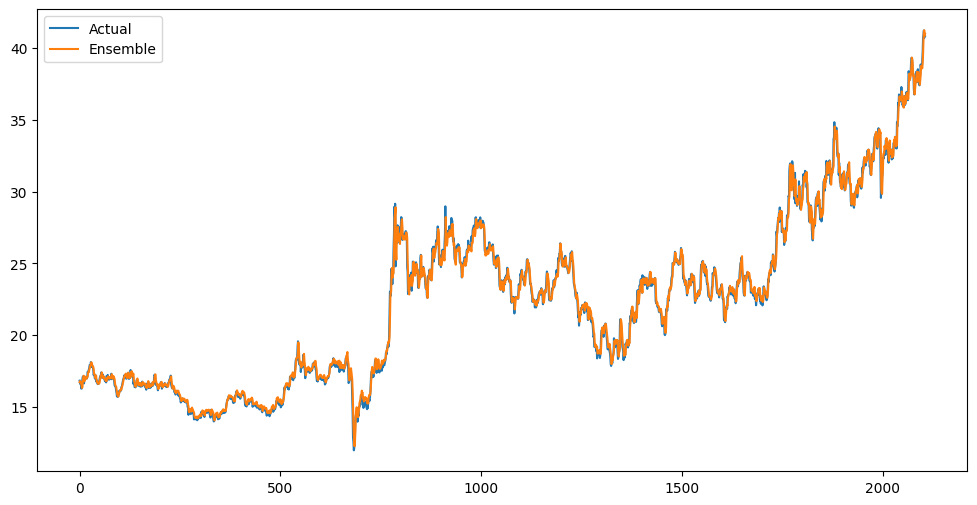

In [17]:
best_pred = best_alpha*pred_lstm_inv + (1-best_alpha)*pred_gru_inv

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual")
plt.plot(best_pred, label="Ensemble")
plt.legend()
plt.show()


In [18]:
print("Jumlah data:", len(df))
print("Time step:", time_step)


Jumlah data: 10562
Time step: 30
